# Roburst Person Identiification using Pretrained Embedding Generator

### **Step 1**: Train & Valid Split
- Split the data into training and validation sets.

### **Step 2**: Contrastive Learning Pair Generation
- Generate pairs of similar and dissimilar samples for contrastive learning.

### **Step 3**: **Embedding Generator Development**
- Develop and train the embedding generator model.

### **Step 4**: **Model Performance Evaluation**
- Evaluate the model performance using appropriate metrics on different Datasetss.


### **Step 1**: Train & Valid Split


![Data Preparation](https://raw.githubusercontent.com/RanaweeraHK/Identification-model-using-ECG-data/main/img/data%20prearation.png)


In [3]:
import wfdb
import numpy as np
import random
import os
import pywt
from sklearn.model_selection import train_test_split
import numpy as np


def load_lead_ii(record_path):
    record = wfdb.rdrecord(record_path)
    lead_ii = record.p_signal[:, 0]
    return lead_ii

def add_random_distortion(ecg_signal, fs=360):
    t = np.linspace(0, len(ecg_signal)/fs, len(ecg_signal), endpoint=False)
    
    def add_powerline_interference(signal):
        power_line_frequency = 60
        pli_amplitude = np.random.uniform(0.05, 0.15) * np.max(signal)
        pli_signal = pli_amplitude * np.sin(2 * np.pi * power_line_frequency * t)
        return signal + pli_signal

    def add_baseline_wander(signal):
        baseline_wander_frequency = np.random.uniform(0.1, 1)
        baseline_wander_amplitude = np.random.uniform(0.02, 0.07) * np.max(signal)
        baseline_wander = baseline_wander_amplitude * np.sin(2 * np.pi * baseline_wander_frequency * t)
        return signal + baseline_wander

    def add_gaussian_noise(signal):
        noise_amplitude = np.random.uniform(0.005, 0.02) * np.max(signal)
        noise = noise_amplitude * np.random.normal(size=len(signal))
        return signal + noise

    def add_random_spikes(signal):
        num_spikes = np.random.randint(5, 20)
        spike_amplitude = np.random.uniform(0.1, 0.3) * np.max(signal)
        spike_indices = np.random.choice(len(signal), num_spikes, replace=False)
        signal_with_spikes = np.copy(signal)
        for index in spike_indices:
            spike = spike_amplitude * (np.random.choice([-1, 1]))
            signal_with_spikes[index] += spike
        return signal_with_spikes

    def corrupt_wavelet_coefficients(signal):
        coeffs = pywt.wavedec(signal, 'db4', level=4)
        level_to_corrupt = np.random.choice(range(1, 3))
        corruption_strength = np.random.uniform(0.05, 0.2)
        coeffs[level_to_corrupt] += corruption_strength * np.random.randn(*coeffs[level_to_corrupt].shape)
        corrupted_signal = pywt.waverec(coeffs, 'db4')
        return corrupted_signal[:len(signal)]

    distortions = [
        add_powerline_interference, 
        add_baseline_wander, 
        add_gaussian_noise, 
        add_random_spikes,
#         corrupt_wavelet_coefficients
    ]
    
    chosen_distortion = random.choice(distortions)
    distorted_signal = chosen_distortion(ecg_signal)
    
    
    return distorted_signal

def extract_10sec_windows(lead_ii, num_samples=180, window_size=360*10):
    windows = []
    total_length = len(lead_ii)
    max_windows = total_length // window_size
    num_samples=max_windows

#     if max_windows < num_samples:
#         num_samples=max_windows
# #         raise ValueError(f"Cannot extract {num_samples} non-overlapping windows, only {max_windows} available.")
    
    for i in range(num_samples):
        start = i * window_size
        end = start + window_size
        window = lead_ii[start:end]
        windows.append(window)
    
    return np.array(windows)

def scale_signal(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    return (signal - min_val) / (max_val - min_val)

def process_mit_bih_data(data_directory, num_samples=180):
    patient_data = {}
    
    for record in os.listdir(data_directory):
        if record.endswith('.dat'):
            record_name = os.path.splitext(record)[0]
            record_path = os.path.join(data_directory, record_name)
            
            lead_ii = load_lead_ii(record_path)
            
            total_duration = len(lead_ii) // 360
            if total_duration < 30:
                raise ValueError(f"Record {record_name} is shorter than 30 minutes.")

            # Split into 25-min train and 5-min test
            train_segment = lead_ii[:25*360*60]
            test_segment = lead_ii[25*360*60:]
            
            # Extract 1-minute windows from train segment
            train_windows = extract_10sec_windows(train_segment, num_samples)
            test_windows = extract_10sec_windows(test_segment, num_samples // 5)
            
            # Add distortions to both train and test segments
#             distorted_train_windows = np.array([add_random_distortion(window) for window in train_windows])
#             distorted_test_windows = np.array([add_random_distortion(window) for window in test_windows])
            
            # Scale the signals between 0 and 1
            scaled_train_windows = np.array([scale_signal(window) for window in train_windows])
            scaled_test_windows = np.array([scale_signal(window) for window in test_windows])
            
            # Store the data
            patient_data[record_name] = {
                'train': scaled_train_windows,
                'test': scaled_test_windows
            }
    
    return patient_data

# Example usage
data_directory = 'mit-bih-arrhythmia-database-1.0.0'
patient_data = process_mit_bih_data(data_directory)
import numpy as np
import os

def flatten_patient_data(patient_data):
    X_train = []
    X_test = []
    y_train = []
    y_test = []

    for record_name, data in patient_data.items():
        train_windows = data['train']
        test_windows = data['test']

        # Flatten the training and testing windows
        X_train.extend(train_windows)
        X_test.extend(test_windows)
#         compute_distances
        # Create labels
        num_train_samples = len(train_windows)
        num_test_samples = len(test_windows)

        y_train.extend([record_name] * num_train_samples)
        y_test.extend([record_name] * num_test_samples)

    # Convert lists to numpy arrays
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train).astype(int)
    y_test = np.array(y_test).astype(int)

    return X_train, X_test, y_train, y_test

# Example usage
X_train, X_test, y_train, y_test = flatten_patient_data(patient_data)


# Reshape X_train and X_test to match the input shape expected by the CNN (samples, length of ECG signal, 1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Encode labels to integers
unique_labels = np.unique(y_train)
label_map = {label: index for index, label in enumerate(unique_labels)}
y_train = np.array([label_map[label] for label in y_train])
y_test = np.array([label_map[label] for label in y_test])

num_classes = len(unique_labels)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (7200, 3600, 1)
X_test shape: (1440, 3600, 1)
y_train shape: (7200,)
y_test shape: (1440,)


(7200, 3600, 1)

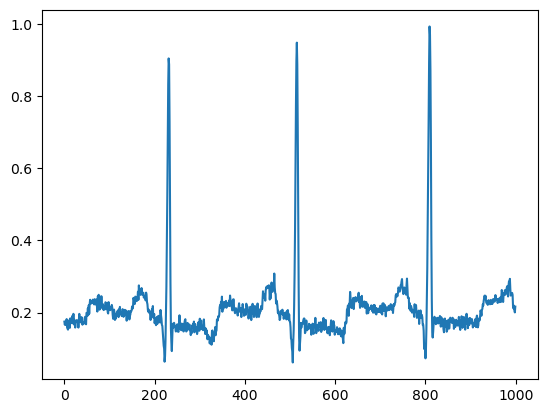

In [8]:
import matplotlib.pyplot as plt
plt.plot(X_train[0].reshape(-1)[1000:2000])
X_train.shape

### Model Archeitecture

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
def create_CNN_model(input_shape):
    model = models.Sequential([
        layers.Conv1D(64, kernel_size=36, activation='relu', padding='same', input_shape=input_shape),  # ~1 second of data
        layers.MaxPooling1D(pool_size=2),
        
        layers.Conv1D(128, kernel_size=18, activation='relu', padding='same'),  # ~0.5 second of data
        layers.MaxPooling1D(pool_size=2),
        
        layers.Conv1D(256, kernel_size=9, activation='relu', padding='same'),  # ~0.25 second of data
        layers.MaxPooling1D(pool_size=2),
        
        layers.Conv1D(512, kernel_size=5, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        
        layers.Conv1D(1024, kernel_size=3, activation='relu', padding='same'),
        
        layers.GlobalAveragePooling1D(),
        layers.Dense(1024, activation=None),  # Embedding layer
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))  # Normalize the embeddings
    ])
    return model

input_shape = (X_train.shape[1], 1)
cnn_model = create_CNN_model(input_shape)


#### Contrastive Loss

![Contrastive Loss](https://raw.githubusercontent.com/RanaweeraHK/Identification-model-using-ECG-data/main/img/contrastive%20loss.png)


In [10]:

from tensorflow.keras import backend as K

# Contrastive Loss Function
def contrastive_loss(y_true, y_pred, margin=2.0):
    # Ensure y_true is float32 to match y_pred's type
    y_true = tf.cast(y_true, y_pred.dtype)
    
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


In [11]:
from tensorflow.keras import backend as K

def euclidean_distance(vectors):
    (featA, featB) = vectors
    sum_squared = K.sum(K.square(featA - featB), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))

# Create the Siamese network
def create_siamese_network(input_shape):
    input_A = layers.Input(shape=input_shape)
    input_B = layers.Input(shape=input_shape)
    
    # Pass both inputs through the FaceNet model
    embeddings_A = cnn_model(input_A)
    embeddings_B = cnn_model(input_B)
    
    # Compute the Euclidean distance between the embeddings
    distance = layers.Lambda(euclidean_distance)([embeddings_A, embeddings_B])
    
    # The Siamese network will output the distance between the embeddings
    siamese_network = models.Model(inputs=[input_A, input_B], outputs=distance)
    return siamese_network

siamese_network = create_siamese_network(input_shape)
siamese_network.compile(loss=contrastive_loss, optimizer='adam')


In [12]:
def create_pairs(X, y ,fs=360):
    pairs = []
    labels = []
    num_classes = len(np.unique(y))
    indices = [np.where(y == i)[0] for i in range(num_classes)]



    for idx1 in range(len(X)):
        # Select a random positive example
        idx2 = random.choice(indices[y[idx1]])

        # select a random k
        # k = random.randint(0, 3)
        ecg_siganl=X[idx2]
        ecg_siganl=ecg_siganl.reshape(-1)

        ecg_siganl=add_random_distortion(ecg_siganl)

        scaled=scale_signal(ecg_siganl)
        
        scaled=scaled.reshape(3600,1)
        scaled_Achor=scale_signal(X[idx1])

        pairs.append([scaled,scaled_Achor ])
        labels.append(1)




        neg_idx = np.random.choice(np.where(y != y[idx1])[0])
        
        neg_ecg_siganl=X[neg_idx]


        neg_ecg_siganl=scale_signal(neg_ecg_siganl)
        
        pairs.append([neg_ecg_siganl,scaled_Achor ])
        labels.append(0)
    return np.array(pairs), np.array(labels)

# Create pairs for training and testing
pairs_train, labels_train = create_pairs(X_train, y_train)
pairs_test, labels_test = create_pairs(X_test, y_test)
labels_train=labels_train.astype(int)
labels_test=labels_test.astype(int)

### Training 

In [133]:
# Train the Siamese network
history = siamese_network.fit(
    [pairs_train[:, 0], pairs_train[:, 1]], labels_train,
    validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test),
    batch_size=32,
    epochs=20
)

Epoch 1/20
450/450 [==============================] - 1335s 3s/step - loss: 0.7661 - val_loss: 0.6386
Epoch 2/20
450/450 [==============================] - 1162s 3s/step - loss: 0.5618 - val_loss: 0.4817
Epoch 3/20
450/450 [==============================] - 610s 1s/step - loss: 0.4298 - val_loss: 0.3839
Epoch 4/20
450/450 [==============================] - 255s 567ms/step - loss: 0.3770 - val_loss: 0.3522
Epoch 5/20
450/450 [==============================] - 228s 506ms/step - loss: 0.3315 - val_loss: 0.3012
Epoch 6/20
450/450 [==============================] - 235s 523ms/step - loss: 0.3037 - val_loss: 0.2798
Epoch 7/20
450/450 [==============================] - 221s 491ms/step - loss: 0.2906 - val_loss: 0.2835
Epoch 8/20
450/450 [==============================] - 222s 494ms/step - loss: 0.2829 - val_loss: 0.2750
Epoch 9/20
450/450 [==============================] - 221s 491ms/step - loss: 0.2736 - val_loss: 0.2747
Epoch 10/20
450/450 [==============================] - 243s 539ms/step 

In [134]:
cnn_model.save('final_non_overlapping.h5')

In [13]:
# Train the Siamese network
history = siamese_network.fit(
    [pairs_train[:, 0], pairs_train[:, 1]], labels_train,
    validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test),
    batch_size=32,
    epochs=20
)

Epoch 1/20
309/450 [===================>..........] - ETA: 2:54 - loss: 0.9198


KeyboardInterrupt



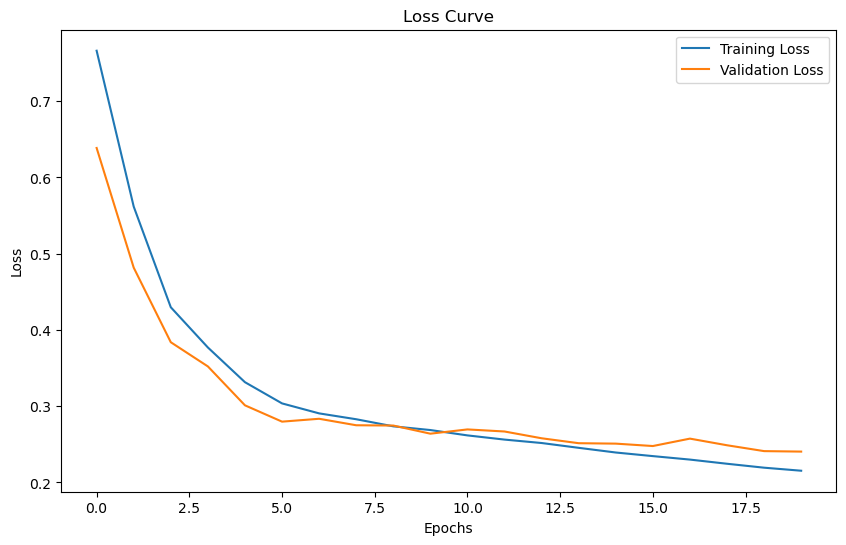

In [135]:
import matplotlib.pyplot as plt

# Assuming 'history' contains the training history returned by the 'fit' method
def plot_loss_curve(history):
    plt.figure(figsize=(10, 6))

    # Plot training loss
    plt.plot(history.history['loss'], label='Training Loss')

    # Plot validation loss
    plt.plot(history.history['val_loss'], label='Validation Loss')

    # Adding title and labels
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Show plot
    plt.show()

# Call the function with your history object
plot_loss_curve(history)

In [5]:
# Step 2: Implement a custom kNN algorithm
def custom_knn(embeddings_train, labels_train, embeddings_test, k=5):
    predictions = []
    
    for test_embedding in embeddings_test:
        # Calculate the Euclidean distance between the test embedding and all train embeddings
        distances = np.linalg.norm(embeddings_train - test_embedding, axis=1)
        
        # Get the indices of the k-nearest neighbors
        knn_indices = np.argsort(distances)[:k]
        
        # Get the labels of the k-nearest neighbors
        knn_labels = labels_train[knn_indices]
        
        # Determine the most common label among the k-nearest neighbors
        unique_labels, counts = np.unique(knn_labels, return_counts=True)
        predicted_label = unique_labels[np.argmax(counts)]
        
        predictions.append(predicted_label)
    
    return np.array(predictions)


In [2]:
import tensorflow as tf
cnn_model = tf.keras.models.load_model('final_non_overlapping.h5',compile=False)


## Step 4  : Model Performance Evaluation

###  Visualization of Embeddings generated for the pretrained Embedding Generator for MIT Train set

Silhouette Score: 0.6525810956954956


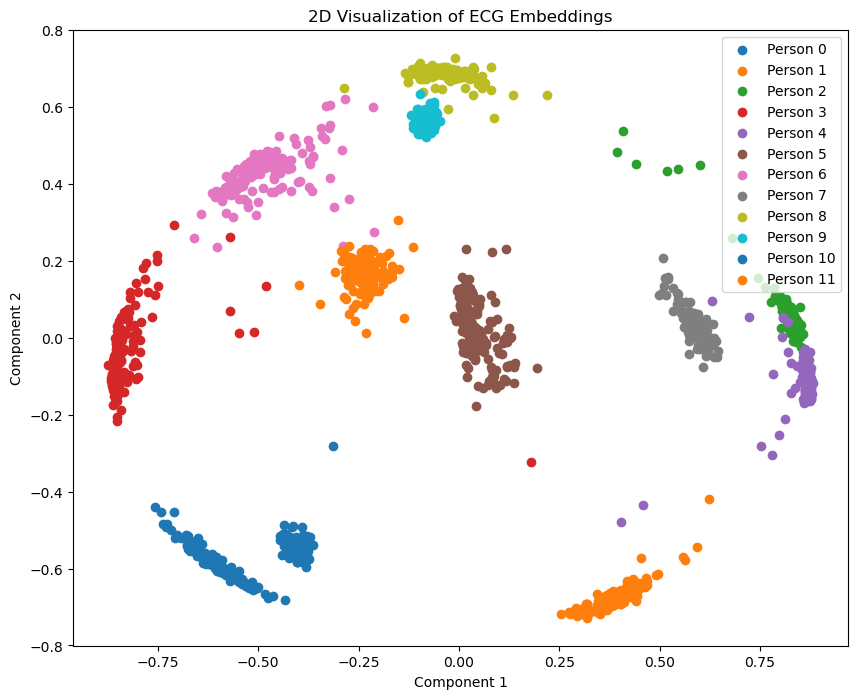

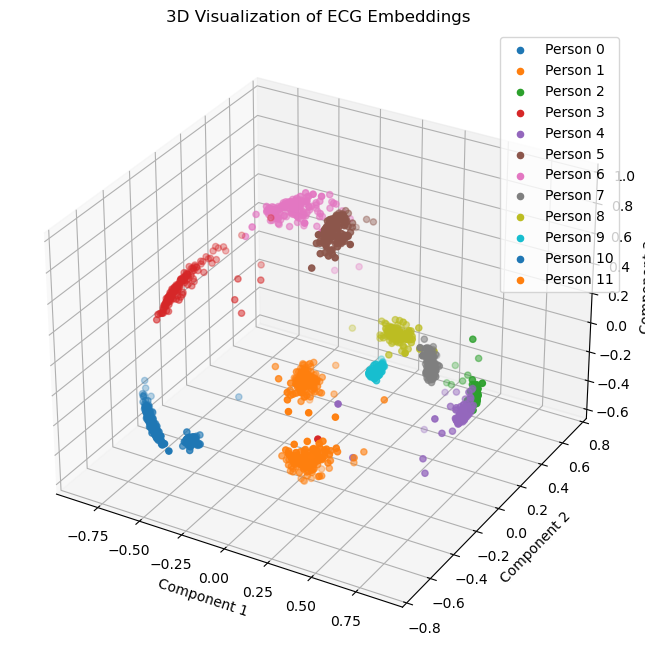

In [292]:
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the saved embedding model
# embedding_model = arcface_facenet_model
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(embeddings_train, y_train)
print(f"Silhouette Score: {silhouette_avg}")
# Generate embeddings for the test set
X_test_embeddings = embeddings_train[:1800]
y_test_embedding=y_train[:1800]


# Use PCA or t-SNE for dimensionality reduction
def reduce_dimensionality(embeddings, method='tsne', n_components=2):
    if method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=42)
        print(reducer)
    elif method == 'pca':
        reducer = PCA(n_components=n_components)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'")
    
    reduced_embeddings = reducer.fit_transform(embeddings)
    return reduced_embeddings

# Reduce embeddings to 2D for visualization
try:
    reduced_embeddings_2d = reduce_dimensionality(X_test_embeddings, method='pca', n_components=2)
except Exception as e:
    print(f"Error during dimensionality reduction: {e}")

# Ensure y_test is a numpy array and has the same length as reduced_embeddings_2d
# y_test = np.array(y_test[:60])

# Plot the 2D vector space
plt.figure(figsize=(10, 8))
try:
    for label in np.unique(y_test_embedding):
        indices = np.where(y_test_embedding == label)
        plt.scatter(reduced_embeddings_2d[indices, 0], reduced_embeddings_2d[indices, 1], label=f'Person {label}')
    plt.title('2D Visualization of ECG Embeddings')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Error during plotting: {e}")

# Reduce embeddings to 3D for visualization
try:
    reduced_embeddings_3d = reduce_dimensionality(X_test_embeddings, method='pca', n_components=3)
except Exception as e:
    print(f"Error during dimensionality reduction to 3D: {e}")

# Plot the 3D vector space
fig = plt.figure(figsize=(10, 8))
try:
    ax = fig.add_subplot(111, projection='3d')
    for label in np.unique(y_test_embedding):
        indices = np.where(y_test_embedding == label)
        ax.scatter(reduced_embeddings_3d[indices, 0], reduced_embeddings_3d[indices, 1], reduced_embeddings_3d[indices, 2], label=f'Person {label}')
    ax.set_title('3D Visualization of ECG Embeddings')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Error during 3D plotting: {e}")


###  Visualization of Embeddings generated for the pretrained Embedding Generator for MIT Test set

Silhouette Score: 0.6503238677978516


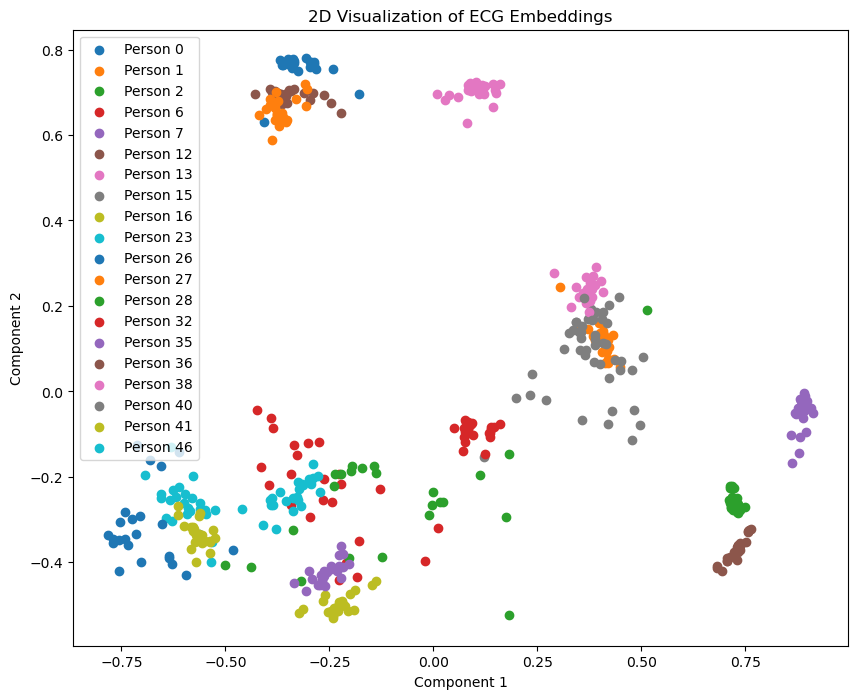

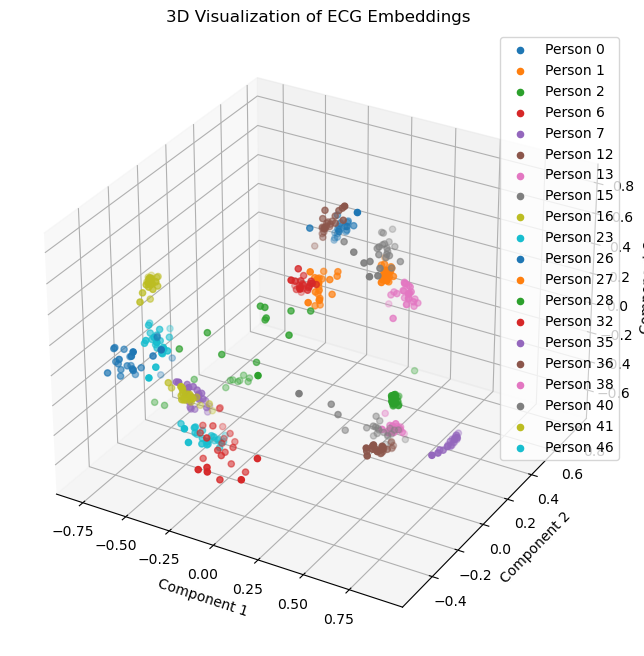

In [296]:
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


silhouette_avg = silhouette_score(embeddings_vec, y_vec)
print(f"Silhouette Score: {silhouette_avg}")
# Load the saved embedding model
# embedding_model = arcface_facenet_model
unique_classes = np.random.choice(np.unique(y_vec), 20, replace=False)

# Create a mask to select only those embeddings and labels corresponding to the 5 unique classes
mask = np.isin(y_vec, unique_classes)

# Filter the embeddings and labels
filtered_embeddings_train = embeddings_vec[mask]
filtered_ptb_y_train = y_vec[mask]
# Generate embeddings for the test set
X_test_embeddings = filtered_embeddings_train[:1800]
y_test_embedding=filtered_ptb_y_train[:1800]


from sklearn.metrics import silhouette_score

# Assume `embeddings` is the output from your model and `labels` are the true labels



# Use PCA or t-SNE for dimensionality reduction
def reduce_dimensionality(embeddings, method='tsne', n_components=2):
    if method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=42)
        print(reducer)
    elif method == 'pca':
        reducer = PCA(n_components=n_components)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'")
    
    reduced_embeddings = reducer.fit_transform(embeddings)
    return reduced_embeddings

# Reduce embeddings to 2D for visualization
try:
    reduced_embeddings_2d = reduce_dimensionality(X_test_embeddings, method='pca', n_components=2)
except Exception as e:
    print(f"Error during dimensionality reduction: {e}")

# Ensure y_test is a numpy array and has the same length as reduced_embeddings_2d
# y_test = np.array(y_test[:60])

# Plot the 2D vector space
plt.figure(figsize=(10, 8))
try:
    for label in np.unique(y_test_embedding):
        indices = np.where(y_test_embedding == label)
        plt.scatter(reduced_embeddings_2d[indices, 0], reduced_embeddings_2d[indices, 1], label=f'Person {label}')
    plt.title('2D Visualization of ECG Embeddings')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Error during plotting: {e}")

# Reduce embeddings to 3D for visualization
try:
    reduced_embeddings_3d = reduce_dimensionality(X_test_embeddings, method='pca', n_components=3)
except Exception as e:
    print(f"Error during dimensionality reduction to 3D: {e}")

# Plot the 3D vector space
fig = plt.figure(figsize=(10, 8))
try:
    ax = fig.add_subplot(111, projection='3d')
    for label in np.unique(y_test_embedding):
        indices = np.where(y_test_embedding == label)
        ax.scatter(reduced_embeddings_3d[indices, 0], reduced_embeddings_3d[indices, 1], reduced_embeddings_3d[indices, 2], label=f'Person {label}')
    ax.set_title('3D Visualization of ECG Embeddings')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Error during 3D plotting: {e}")


## Person Identification using Test Set (KNN)

In [302]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score

# Step 1: Generate embeddings for the test data
def generate_embeddings(model, X):
    embeddings = model.predict(X)
    return embeddings
X_vec, X_cls, y_vec, y_cls = train_test_split(X_test, y_test, test_size=0.2, random_state=42, stratify=y_test)
print("training datat for KNN",X_vec.shape)
print("validation data for KNN",X_cls.shape)
print("no of pereson",y_cls.shape)
# Generate embeddings for the train set
embeddings_vec = generate_embeddings(cnn_model, X_vec)


# Generate embeddings for the test set
embeddings_cls = generate_embeddings(cnn_model, X_cls)




 # Use the custom kNN algorithm to predict the class of each test embedding
predicted_labels = custom_knn(embeddings_vec, y_vec, embeddings_cls, k=5)

 # Calculate precision, recall, and confusion matrix
precision = precision_score(y_cls, predicted_labels, average='macro')
recall = recall_score(y_cls, predicted_labels, average='macro')
conf_matrix = confusion_matrix(y_cls, predicted_labels)



f1_score_=f1_score(y_cls, predicted_labels, average='macro')

print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score:" + str(f1_score_ ))

print("Confusion Matrix:\n", conf_matrix)


training datat for KNN (1152, 3600, 1)
validation data for KNN (288, 3600, 1)
no of pereson (288,)
9/9 [==============================] - 1s 55ms/step
Precision: 99.48%
Recall: 99.31%
F1 Score:0.9928571428571429
Confusion Matrix:
 [[6 0 0 ... 0 0 0]
 [0 6 0 ... 0 0 0]
 [0 0 6 ... 0 0 0]
 ...
 [0 0 0 ... 6 0 0]
 [0 0 0 ... 0 6 0]
 [0 0 0 ... 0 0 6]]


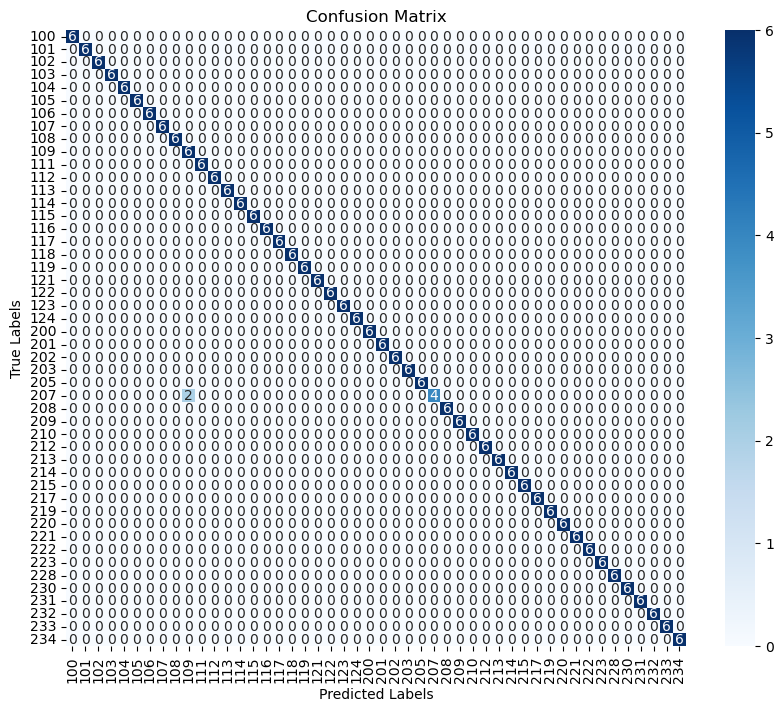

In [295]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_cls, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]


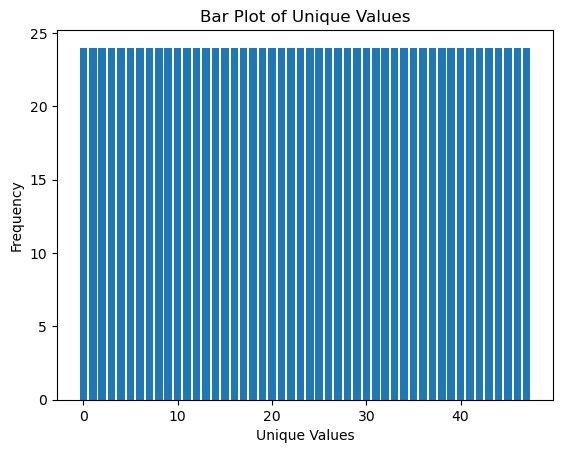

In [147]:
unique, frequency = np.unique(y_vec,
                              return_counts = True) 
print(unique)

plt.bar(unique, frequency)
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.title('Bar Plot of Unique Values')
plt.show()

### Testing of Model Perfomance on St Peter'sBurg 

21799 clinical 12-lead ECGs from 18869 patients of 10 second length

![St. Peter's Burg](https://raw.githubusercontent.com/RanaweeraHK/Identification-model-using-ECG-data/main/img/stPeter'sBurg.png)


75 patients
fs: 257 length: 1800.0 s
fs: 257 length: 1800.0 s
fs: 257 length: 1800.0 s


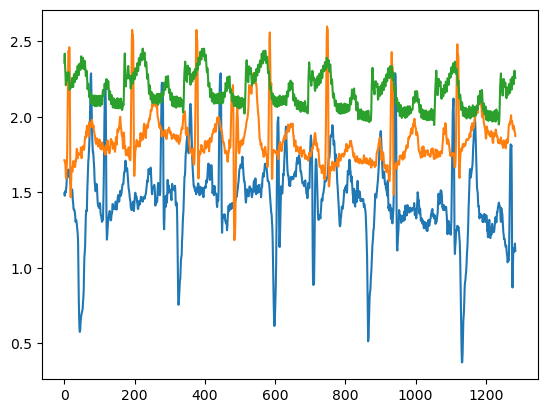

In [76]:
def load_a_lead_ii(record_path):
    # Load the ECG record using wfdb
    record = wfdb.rdrecord(record_path)
    
    # Extract Lead II (usually the second channel)
    lead_ii = record.p_signal[:, 1]
    fs=wfdb.rdheader(record_path).fs
    print('fs:',fs,'length:',(len(lead_ii))/fs,'s', )
    plt.plot(lead_ii[:fs*5])
    
    
#     print(wfdb.rdheader(record_path).fs)
    return lead_ii
data_directory='files'
print('75','patients')
for record in os.listdir(data_directory)[:10]:
    if record.endswith('.dat'):
        load_a_lead_ii('files/'+os.path.splitext(record)[0])

In [35]:
import wfdb
import numpy as np
import random
import os
import pywt
def load_lead_ii(record_path):
    # Load the ECG record using wfdb
    record = wfdb.rdrecord(record_path)
    # Extract Lead II (usually the second channel)
    lead_ii = record.p_signal[:, 1]  # Assuming Lead II is the second lead
    return lead_ii


import numpy as np

def extract_1_minute_windows(lead_ii, num_samples=180, window_size=257*10):
    windows = []
    total_length = len(lead_ii)
    
    # Calculate the number of possible non-overlapping windows
    max_windows = total_length // window_size
    num_samples=num_samples
    
#     if max_windows < num_samples:
#         raise ValueError(f"Cannot extract {num_samples} non-overlapping windows, only {max_windows} available.")
    
    # Extract non-overlapping windows
    for i in range(num_samples):
        start = i * window_size
        end = start + window_size
        window = lead_ii[start:end]
        windows.append(window)
    
    return np.array(windows)


def scale_signal(signal):
    # Scale the signal between 0 and 1
    min_val = np.min(signal)
    max_val = np.max(signal)
    return (signal - min_val) / (max_val - min_val)

def process_mit_bih_data(data_directory, num_samples=180):
    patient_data = {}
    
    for record in os.listdir(data_directory):
        if record.endswith('.dat'):
            record_name = os.path.splitext(record)[0]
            record_path = os.path.join(data_directory, record_name)
            
            # Load Lead II
            lead_ii = load_lead_ii(record_path)
            
            # Extract 1-minute windows
            windows = extract_1_minute_windows(lead_ii, num_samples)
            
            # Add distortions
#             distorted_windows = np.array([add_random_distortion(window) for window in windows])
            
            # Scale the signals between 0 and 1
            scaled_windows = np.array([scale_signal(window) for window in windows])
            
            # Store the data
            patient_data[record_name] = scaled_windows
            
       
                
    return patient_data


# Example usage
data_directory = 'files'
patient_data = process_mit_bih_data(data_directory)

# Now patient_data contains 30 distorted and scaled 1-minute windows for each patient.


In [41]:
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.signal import resample

# Assuming `patient_data` is a dictionary with patient IDs as keys and their corresponding 1-minute ECG windows as values.

# Convert the dictionary to lists for processing
X = []
y = []

for patient_id, windows in patient_data.items():
    for window in windows:
        
        window = resample(window, 3600)

        X.append(window)
        y.append(patient_id)

X = np.array(X)
y = np.array(y)

In [341]:
print("no of patients ",len(np.unique(y)))

no of patients  75


### Model Performance using KNN as Classfier

In [37]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix,f1_score
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
# cnn_model = tf.keras.models.load_model('final_margin_2.0_no_wavelet_corruption.h5',compile=False)

cnn_model = tf.keras.models.load_model('final_non_overlapping.h5',compile=False)
# cnn_model = tf.keras.models.load_model('final_98.h5',compile=False)

# oversample = SMOTE()
# ecg_data_list, labels = ADASYN().fit_resample(ecg_data_list,labels)
ptbxl_X=X.reshape(-1, 3600, 1)
ptbxl_y=y
ptb_X_train, ptb_X_test, ptb_y_train, ptb_y_test = train_test_split(ptbxl_X, ptbxl_y, test_size=0.2, random_state=42)

# Step 1: Generate embeddings for the test data
def generate_embeddings(model, X_):
    embeddings = model.predict(X_)
    return embeddings

# Generate embeddings for the train set
embeddings_train = generate_embeddings(cnn_model, ptb_X_train)

# Generate embeddings for the test set
embeddings_test = generate_embeddings(cnn_model, ptb_X_test)


print(embeddings_train.shape)

# Use the custom kNN algorithm to predict the class of each test embedding
predicted_labels = custom_knn(embeddings_train, ptb_y_train, embeddings_test, k=5)
accuracy = accuracy_score(ptb_y_test, predicted_labels)

# Calculate precision, recall, and confusion matrix
precision = precision_score(ptb_y_test, predicted_labels, average='macro')
recall = recall_score(ptb_y_test, predicted_labels, average='macro')
conf_matrix = confusion_matrix(ptb_y_test, predicted_labels)

# print("Precision: {:.2f}%".format(precision * 100))
# print("Recall: {:.2f}%".format(recall * 100))
f1_score_=f1_score(ptb_y_test, predicted_labels, average='macro')
# print(accuracy)
print("Accuracy: {:.2f}%".format(accuracy * 100))

print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score:" + str(f1_score_ ))
print("Confusion Matrix:\n", conf_matrix)


85/85 [==============================] - 5s 58ms/step
(10800, 512)
Accuracy: 86.41%
Precision: 86.60%
Recall: 86.48%
F1 Score:0.8602408542408488
Confusion Matrix:
 [[33  8  0 ...  0  0  0]
 [ 1 32  0 ...  0  0  0]
 [ 0  0 41 ...  0  0  0]
 ...
 [ 0  0  0 ... 35  0  0]
 [ 0  0  0 ...  0 35  6]
 [ 0  0  0 ...  0  0 45]]


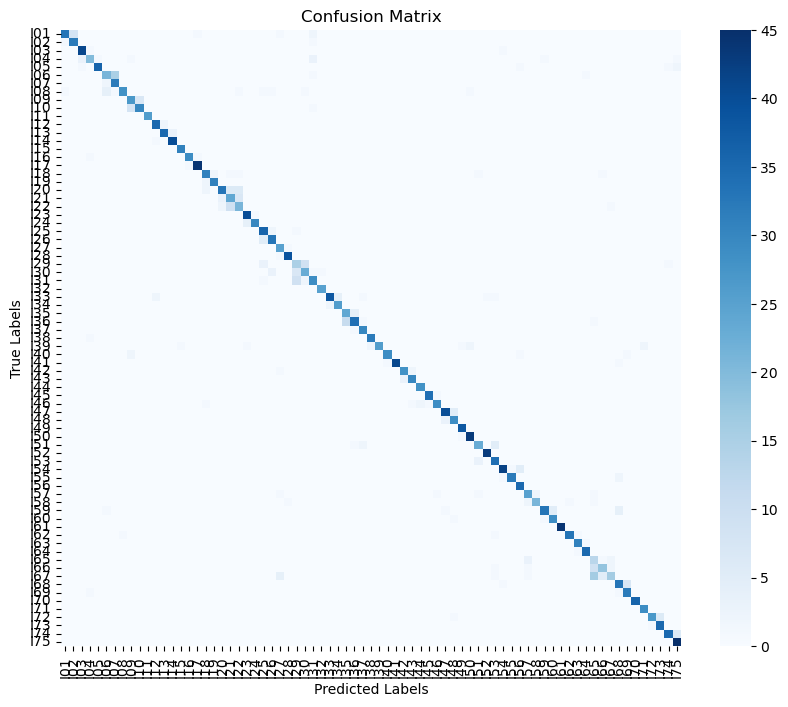

In [347]:

unique_labels = np.unique(ptb_y_test)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix,  fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Silhouette Score: 0.11572533845901489


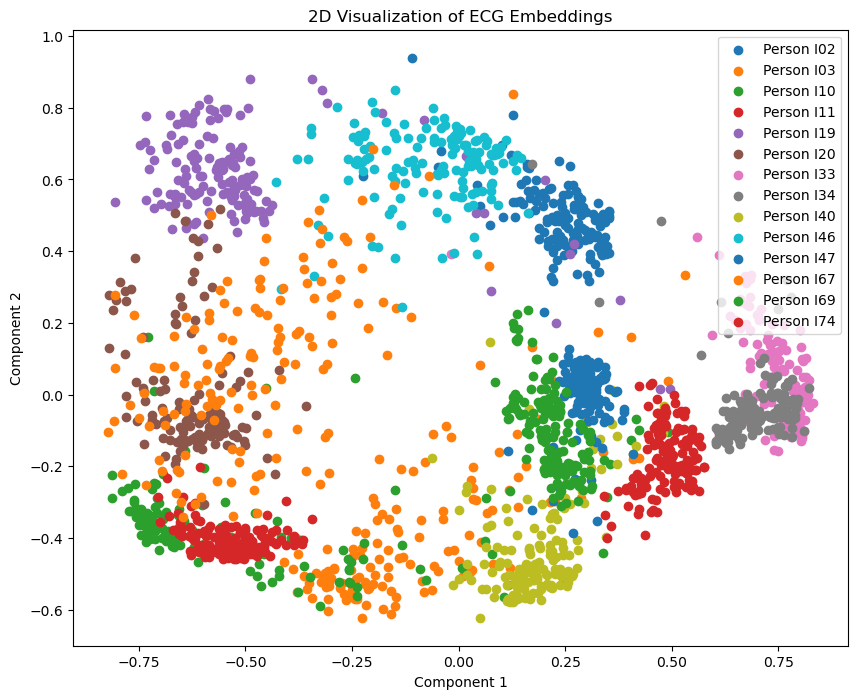

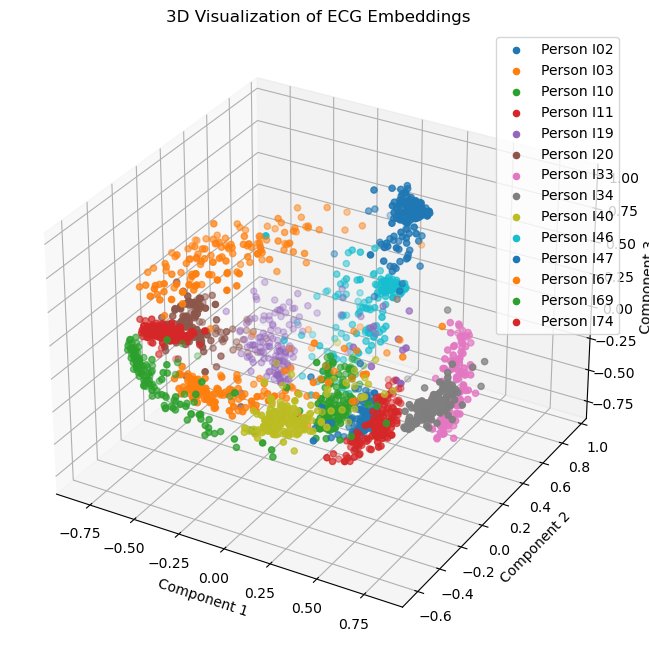

In [350]:
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score

# Assume `embeddings` is the output from your model and `labels` are the true labels
silhouette_avg = silhouette_score(embeddings_train, ptb_y_train)
print(f"Silhouette Score: {silhouette_avg}")

# Load the saved embedding model
# embedding_model = arcface_facenet_model
unique_classes = np.random.choice(np.unique(ptb_y_train), 14, replace=False)

# Create a mask to select only those embeddings and labels corresponding to the 5 unique classes
mask = np.isin(ptb_y_train, unique_classes)

# Filter the embeddings and labels
filtered_embeddings_train = embeddings_train[mask]
filtered_ptb_y_train = ptb_y_train[mask]
# Generate embeddings for the test set
X_test_embeddings = filtered_embeddings_train
y_test=filtered_ptb_y_train
# Use PCA or t-SNE for dimensionality reduction
def reduce_dimensionality(embeddings, method='tsne', n_components=2):
    if method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=42)
        print(reducer)
    elif method == 'pca':
        reducer = PCA(n_components=n_components)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'")
    
    reduced_embeddings = reducer.fit_transform(embeddings)
    return reduced_embeddings

# Reduce embeddings to 2D for visualization
try:
    reduced_embeddings_2d = reduce_dimensionality(X_test_embeddings, method='pca', n_components=2)
except Exception as e:
    print(f"Error during dimensionality reduction: {e}")

# Ensure y_test is a numpy array and has the same length as reduced_embeddings_2d
# y_test = np.array(y_test[:60])

# Plot the 2D vector space
plt.figure(figsize=(10, 8))
try:
    for label in np.unique(y_test):
        indices = np.where(y_test == label)
        plt.scatter(reduced_embeddings_2d[indices, 0], reduced_embeddings_2d[indices, 1], label=f'Person {label}')
    plt.title('2D Visualization of ECG Embeddings')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Error during plotting: {e}")

# Reduce embeddings to 3D for visualization
try:
    reduced_embeddings_3d = reduce_dimensionality(X_test_embeddings, method='pca', n_components=3)
except Exception as e:
    print(f"Error during dimensionality reduction to 3D: {e}")

# Plot the 3D vector space
fig = plt.figure(figsize=(10, 8))
try:
    ax = fig.add_subplot(111, projection='3d')
    for label in np.unique(y_test):
        indices = np.where(y_test == label)
        ax.scatter(reduced_embeddings_3d[indices, 0], reduced_embeddings_3d[indices, 1], reduced_embeddings_3d[indices, 2], label=f'Person {label}')
    ax.set_title('3D Visualization of ECG Embeddings')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Error during 3D plotting: {e}")


## Nueral network as a classifier

85/85 [==============================] - 6s 72ms/step
Epoch 1/1000
304/304 [==============================] - 1s 2ms/step - loss: 2.8227 - accuracy: 0.2600 - val_loss: 1.3563 - val_accuracy: 0.6185
Epoch 2/1000
304/304 [==============================] - 1s 2ms/step - loss: 1.5477 - accuracy: 0.4868 - val_loss: 0.9759 - val_accuracy: 0.7130
Epoch 3/1000
304/304 [==============================] - 1s 2ms/step - loss: 1.2659 - accuracy: 0.5664 - val_loss: 0.8251 - val_accuracy: 0.7509
Epoch 4/1000
304/304 [==============================] - 1s 2ms/step - loss: 1.1170 - accuracy: 0.6120 - val_loss: 0.7480 - val_accuracy: 0.7556
Epoch 5/1000
304/304 [==============================] - 1s 2ms/step - loss: 1.0140 - accuracy: 0.6490 - val_loss: 0.6857 - val_accuracy: 0.7824
Epoch 6/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.9639 - accuracy: 0.6594 - val_loss: 0.6246 - val_accuracy: 0.8009
Epoch 7/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.9131

Epoch 57/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.4912 - accuracy: 0.8172 - val_loss: 0.3612 - val_accuracy: 0.8639
Epoch 58/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.4821 - accuracy: 0.8194 - val_loss: 0.3398 - val_accuracy: 0.8787
Epoch 59/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.4887 - accuracy: 0.8128 - val_loss: 0.3464 - val_accuracy: 0.8722
Epoch 60/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.4801 - accuracy: 0.8181 - val_loss: 0.3481 - val_accuracy: 0.8759
Epoch 61/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.4841 - accuracy: 0.8151 - val_loss: 0.3535 - val_accuracy: 0.8722
Epoch 62/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.4767 - accuracy: 0.8175 - val_loss: 0.3507 - val_accuracy: 0.8769
Epoch 63/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.4725 - accuracy: 0.8229 - val_loss: 0.3581 - val_ac

304/304 [==============================] - 1s 2ms/step - loss: 0.3690 - accuracy: 0.8586 - val_loss: 0.3040 - val_accuracy: 0.8972
Epoch 170/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.3776 - accuracy: 0.8546 - val_loss: 0.3012 - val_accuracy: 0.8917
Epoch 171/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.3845 - accuracy: 0.8535 - val_loss: 0.2888 - val_accuracy: 0.9009
Epoch 172/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.3732 - accuracy: 0.8550 - val_loss: 0.3045 - val_accuracy: 0.8935
Epoch 173/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.3672 - accuracy: 0.8568 - val_loss: 0.3006 - val_accuracy: 0.8926
Epoch 174/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.3735 - accuracy: 0.8533 - val_loss: 0.2898 - val_accuracy: 0.8972
Epoch 175/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.3666 - accuracy: 0.8549 - val_loss: 0.2907 - val_accuracy: 

304/304 [==============================] - 1s 2ms/step - loss: 0.3393 - accuracy: 0.8655 - val_loss: 0.2906 - val_accuracy: 0.8972
Epoch 282/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.3326 - accuracy: 0.8712 - val_loss: 0.2843 - val_accuracy: 0.9074
Epoch 283/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.3311 - accuracy: 0.8709 - val_loss: 0.2836 - val_accuracy: 0.9093
Epoch 284/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.3317 - accuracy: 0.8698 - val_loss: 0.2894 - val_accuracy: 0.9019
Epoch 285/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.3185 - accuracy: 0.8733 - val_loss: 0.2855 - val_accuracy: 0.9083
Epoch 286/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.3320 - accuracy: 0.8699 - val_loss: 0.2994 - val_accuracy: 0.8972
Epoch 287/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.3353 - accuracy: 0.8693 - val_loss: 0.2790 - val_accuracy: 

304/304 [==============================] - 1s 2ms/step - loss: 0.3125 - accuracy: 0.8762 - val_loss: 0.2890 - val_accuracy: 0.8981
Epoch 394/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.3091 - accuracy: 0.8789 - val_loss: 0.2779 - val_accuracy: 0.9111
Epoch 395/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.3070 - accuracy: 0.8792 - val_loss: 0.2796 - val_accuracy: 0.9000
Epoch 396/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.3142 - accuracy: 0.8755 - val_loss: 0.2750 - val_accuracy: 0.9028
Epoch 397/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.3181 - accuracy: 0.8735 - val_loss: 0.2643 - val_accuracy: 0.9130
Epoch 398/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.3050 - accuracy: 0.8786 - val_loss: 0.2667 - val_accuracy: 0.9046
Epoch 399/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.3093 - accuracy: 0.8779 - val_loss: 0.2701 - val_accuracy: 

304/304 [==============================] - 1s 2ms/step - loss: 0.2953 - accuracy: 0.8824 - val_loss: 0.2804 - val_accuracy: 0.9130
Epoch 506/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2954 - accuracy: 0.8840 - val_loss: 0.2828 - val_accuracy: 0.9102
Epoch 507/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2918 - accuracy: 0.8877 - val_loss: 0.2678 - val_accuracy: 0.9167
Epoch 508/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2939 - accuracy: 0.8878 - val_loss: 0.2806 - val_accuracy: 0.8991
Epoch 509/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2956 - accuracy: 0.8819 - val_loss: 0.2750 - val_accuracy: 0.9167
Epoch 510/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2936 - accuracy: 0.8851 - val_loss: 0.2762 - val_accuracy: 0.9102
Epoch 511/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2981 - accuracy: 0.8840 - val_loss: 0.2696 - val_accuracy: 

304/304 [==============================] - 1s 2ms/step - loss: 0.2897 - accuracy: 0.8885 - val_loss: 0.2669 - val_accuracy: 0.9111
Epoch 618/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2830 - accuracy: 0.8866 - val_loss: 0.2693 - val_accuracy: 0.9102
Epoch 619/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2804 - accuracy: 0.8876 - val_loss: 0.2612 - val_accuracy: 0.9176
Epoch 620/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2673 - accuracy: 0.8942 - val_loss: 0.2741 - val_accuracy: 0.9065
Epoch 621/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2831 - accuracy: 0.8907 - val_loss: 0.2981 - val_accuracy: 0.9102
Epoch 622/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2737 - accuracy: 0.8897 - val_loss: 0.2837 - val_accuracy: 0.9065
Epoch 623/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2717 - accuracy: 0.8908 - val_loss: 0.2711 - val_accuracy: 

304/304 [==============================] - 1s 2ms/step - loss: 0.2776 - accuracy: 0.8890 - val_loss: 0.2745 - val_accuracy: 0.9074
Epoch 730/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2643 - accuracy: 0.8954 - val_loss: 0.2869 - val_accuracy: 0.9074
Epoch 731/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2772 - accuracy: 0.8921 - val_loss: 0.2812 - val_accuracy: 0.9065
Epoch 732/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2599 - accuracy: 0.8970 - val_loss: 0.2684 - val_accuracy: 0.9185
Epoch 733/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2565 - accuracy: 0.8977 - val_loss: 0.2982 - val_accuracy: 0.8963
Epoch 734/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2781 - accuracy: 0.8906 - val_loss: 0.2625 - val_accuracy: 0.9241
Epoch 735/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2690 - accuracy: 0.8954 - val_loss: 0.3036 - val_accuracy: 

304/304 [==============================] - 1s 2ms/step - loss: 0.2736 - accuracy: 0.8933 - val_loss: 0.2936 - val_accuracy: 0.9074
Epoch 842/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2711 - accuracy: 0.8927 - val_loss: 0.3084 - val_accuracy: 0.9046
Epoch 843/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2768 - accuracy: 0.8925 - val_loss: 0.2986 - val_accuracy: 0.9065
Epoch 844/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2662 - accuracy: 0.8933 - val_loss: 0.2897 - val_accuracy: 0.9111
Epoch 845/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2661 - accuracy: 0.8954 - val_loss: 0.2933 - val_accuracy: 0.9111
Epoch 846/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2707 - accuracy: 0.8938 - val_loss: 0.3144 - val_accuracy: 0.9028
Epoch 847/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2570 - accuracy: 0.8960 - val_loss: 0.2881 - val_accuracy: 

304/304 [==============================] - 1s 2ms/step - loss: 0.2545 - accuracy: 0.8957 - val_loss: 0.2799 - val_accuracy: 0.9176
Epoch 954/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2594 - accuracy: 0.8984 - val_loss: 0.2875 - val_accuracy: 0.9093
Epoch 955/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2650 - accuracy: 0.8934 - val_loss: 0.2927 - val_accuracy: 0.9093
Epoch 956/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2610 - accuracy: 0.8945 - val_loss: 0.2770 - val_accuracy: 0.9213
Epoch 957/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2692 - accuracy: 0.8918 - val_loss: 0.2884 - val_accuracy: 0.9046
Epoch 958/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2681 - accuracy: 0.8949 - val_loss: 0.2849 - val_accuracy: 0.9111
Epoch 959/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.2555 - accuracy: 0.8999 - val_loss: 0.2953 - val_accuracy: 

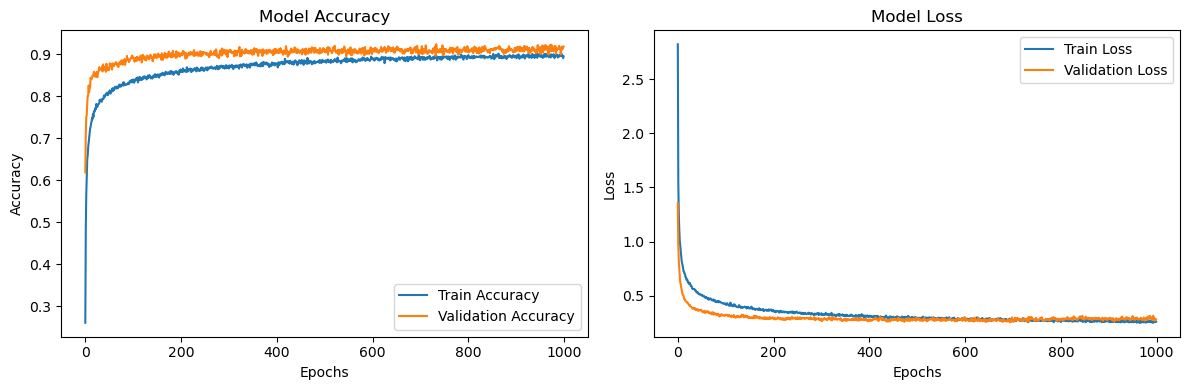

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, accuracy_score
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Load your CNN model
cnn_model = tf.keras.models.load_model('final_non_overlapping.h5', compile=False)

# Reshape the ECG data
ptbxl_X = X.reshape(-1, 3600, 1)
ptbxl_y = y

# Adjust the labels to start from 0
ptbxl_y = ptbxl_y 

# Step 1: Apply Label Encoding to convert class labels into integers
label_encoder = LabelEncoder()
ptbxl_y_encoded = label_encoder.fit_transform(ptbxl_y)

# Split the data
ptb_X_train, ptb_X_test, ptb_y_train, ptb_y_test = train_test_split(ptbxl_X, ptbxl_y_encoded, test_size=0.2, random_state=42)

# Step 2: Generate embeddings for the test data
def generate_embeddings(model, X_):
    embeddings = model.predict(X_)
    return embeddings

# Generate embeddings for the train and test sets
embeddings_train = generate_embeddings(cnn_model, ptb_X_train)
embeddings_test = generate_embeddings(cnn_model, ptb_X_test)

# Step 3: Build a neural network classifier
def build_nn_classifier(input_shape, num_classes):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))  # Output layer for classification
    return model

# Get the number of classes from the unique labels
num_classes = len(np.unique(ptb_y_train))

# Build and compile the neural network classifier
nn_classifier = build_nn_classifier(input_shape=(embeddings_train.shape[1],), num_classes=num_classes)
nn_classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 4: Train the neural network classifier on the embeddings
history = nn_classifier.fit(embeddings_train, ptb_y_train, epochs=1000, batch_size=32, validation_split=0.1)

# Step 5: Use the neural network model to predict the class of each test embedding
predicted_labels = np.argmax(nn_classifier.predict(embeddings_test), axis=1)

# Step 6: Decode the predicted labels back to original form (optional)
predicted_labels_decoded = label_encoder.inverse_transform(predicted_labels)
ptb_y_test_decoded = label_encoder.inverse_transform(ptb_y_test)

# Step 7: Calculate accuracy, precision, recall, and confusion matrix
accuracy = accuracy_score(ptb_y_test_decoded, predicted_labels_decoded)
precision = precision_score(ptb_y_test_decoded, predicted_labels_decoded, average='macro')
recall = recall_score(ptb_y_test_decoded, predicted_labels_decoded, average='macro')
f1_score_ = f1_score(ptb_y_test_decoded, predicted_labels_decoded, average='macro')
conf_matrix = confusion_matrix(ptb_y_test_decoded, predicted_labels_decoded)

# Print the evaluation metrics
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}".format(f1_score_))
print("Confusion Matrix:\n", conf_matrix)

# Step 8: Plot the training history (accuracy and loss)
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### XG Boost as Classifier

In [7]:
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix,f1_score,accuracy_score
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
# cnn_model = tf.keras.models.load_model('final_margin_2.0_no_wavelet_corruption.h5',compile=False)
from sklearn.preprocessing import LabelEncoder
cnn_model = tf.keras.models.load_model('final_non_overlapping.h5',compile=False)
# cnn_model = tf.keras.models.load_model('final_98.h5',compile=False)

# # oversample = SMOTE()
# # ecg_data_list, labels = ADASYN().fit_resample(ecg_data_list,labels)
ptbxl_X=X.reshape(-1, 3600, 1)
ptbxl_y=y
ptb_X_train, ptb_X_test, ptb_y_train, ptb_y_test = train_test_split(ptbxl_X, ptbxl_y, test_size=0.2, random_state=42)

# Step 1: Generate embeddings for the test data
def generate_embeddings(model, X_):
    embeddings = model.predict(X_)
    return embeddings

# Generate embeddings for the train set
embeddings_train = generate_embeddings(cnn_model, ptb_X_train)

# Generate embeddings for the test set
embeddings_test = generate_embeddings(cnn_model, ptb_X_test)


print(embeddings_train.shape)
print(ptb_y_train)



le = LabelEncoder()
le.fit(ptb_y_train)
y_t=le.transform(ptb_y_train)
ptb_y_test=le.transform(ptb_y_test)

# Use the custom kNN algorithm to predict the class of each test embedding
# predicted_labels = custom_knn(embeddings_train, ptb_y_train, embeddings_test, k=5)
model = XGBClassifier(objective='multi:softprob')
model.fit(embeddings_train, y_t)



# make predictions for test data
y_pred = model.predict(embeddings_test)
predictions = [round(value) for value in y_pred]
print(predictions)

# Calculate precision, recall, and confusion matrix
precision = precision_score(ptb_y_test, predictions, average='macro')
recall = recall_score(ptb_y_test, predictions, average='macro')
conf_matrix = confusion_matrix(ptb_y_test, predictions)

# print("Precision: {:.2f}%".format(precision * 100))
# print("Recall: {:.2f}%".format(recall * 100))
f1_score_=f1_score(ptb_y_test, predictions, average='macro')

print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score:" + str(f1_score_ ))
print("Confusion Matrix:\n", conf_matrix)


85/85 [==============================] - 5s 56ms/step
(10800, 512)
['I71' 'I14' 'I46' ... 'I30' 'I05' 'I41']
[8, 28, 6, 36, 61, 64, 51, 30, 57, 2, 46, 71, 16, 7, 48, 17, 51, 5, 37, 58, 29, 35, 41, 8, 53, 21, 46, 59, 51, 35, 6, 72, 48, 63, 6, 54, 34, 47, 2, 62, 19, 40, 32, 27, 14, 44, 0, 13, 2, 39, 15, 46, 32, 11, 44, 52, 19, 58, 16, 5, 49, 73, 53, 15, 43, 1, 64, 57, 71, 6, 48, 56, 29, 14, 52, 2, 40, 36, 39, 12, 36, 68, 70, 18, 24, 24, 23, 64, 52, 65, 59, 54, 23, 52, 36, 35, 24, 40, 60, 35, 19, 61, 64, 59, 7, 34, 40, 19, 20, 49, 12, 42, 54, 73, 61, 38, 57, 30, 41, 1, 14, 23, 22, 4, 64, 43, 50, 56, 9, 42, 14, 57, 23, 35, 9, 60, 49, 18, 53, 63, 51, 63, 14, 54, 25, 52, 40, 27, 48, 16, 11, 4, 29, 12, 27, 51, 14, 60, 56, 26, 56, 60, 3, 16, 73, 43, 20, 16, 45, 73, 23, 39, 6, 32, 7, 71, 60, 10, 22, 40, 48, 40, 57, 63, 21, 60, 55, 61, 35, 47, 30, 35, 62, 45, 31, 38, 19, 14, 6, 59, 60, 66, 56, 0, 62, 44, 9, 46, 38, 73, 13, 67, 9, 18, 19, 34, 70, 26, 38, 38, 5, 25, 2, 65, 1, 63, 13, 43, 23, 40, 2

# PTB Dataset

no of Patients 290
fs: 1000 length: 38.4 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.174 s
fs: 1000 length: 115.174 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.174 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 32.0 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s


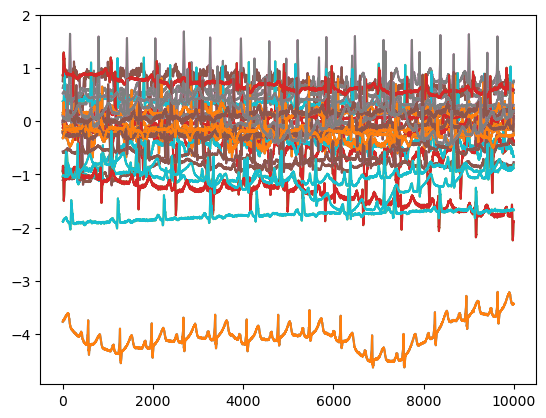

In [304]:
def load_a_lead_ii(record_path):
    # Load the ECG record using wfdb
    record = wfdb.rdrecord(record_path)
    
    # Extract Lead II (usually the second channel)
    lead_ii = record.p_signal[:, 1]
    fs=wfdb.rdheader(record_path).fs
    fs=wfdb.rdheader(record_path).fs
    print('fs:',fs,'length:',(len(lead_ii))/fs,'s', )
    plt.plot(lead_ii[:fs*10])
    plt.plot(lead_ii[:fs*10])
    
    
#     print(wfdb.rdheader(record_path).fs)
    return lead_ii
data_directory='ptb-diagnostic-ecg-database-1.0.0'
print("no of Patients", len(os.listdir(data_directory)))

for patient in os.listdir(data_directory)[:10]:
        for record in os.listdir(data_directory+'/'+patient):
#             print(record)
            if record.endswith('.dat'):
                load_a_lead_ii('ptb-diagnostic-ecg-database-1.0.0/'+patient+'/'+os.path.splitext(record)[0])

### load dataset

In [6]:
import wfdb
import numpy as np
import random
import os
import pywt
def load_lead_ii(record_path):
    # Load the ECG record using wfdb
    record = wfdb.rdrecord(record_path)
#     print(wfdb.rdheader(record_path).fs)
#     print(wfdb.rdheader(record_path).fs)

    # Extract Lead II (usually the second channel)
    lead_ii = record.p_signal[:, 1]  # Assuming Lead II is the second lead
    return lead_ii



import numpy as np

def extract_1_minute_windows(lead_ii,fs):
    window_size=int(fs)*10
    windows = []
    total_length = len(lead_ii)
    
    # Calculate the number of possible non-overlapping windows
    max_windows = total_length // window_size
    num_samples=max_windows
    
#     if max_windows < num_samples:
#         raise ValueError(f"Cannot extract {num_samples} non-overlapping windows, only {max_windows} available.")
    
    # Extract non-overlapping windows
    for i in range(num_samples):
        start = i * window_size
        end = start + window_size
        window = lead_ii[start:end]
        windows.append(window)
    
    return np.array(windows)


def scale_signal(signal):
    # Scale the signal between 0 and 1
    min_val = np.min(signal)
    max_val = np.max(signal)
    return (signal - min_val) / (max_val - min_val)

def process_mit_bih_data(data_directory, num_samples=180):
    patient_data = {}
    p_id=0
    
    for patient in os.listdir(data_directory):
        patient_scalled_window=[]
        p_id=p_id+1
        for record in os.listdir(data_directory+'/'+patient):
#             print(record)
            if record.endswith('.dat'):
                
                
                record_name = os.path.splitext(record)[0]
                record_path =data_directory+'/'+patient+'/'+record_name

                # Load Lead II
#                 lead_ii = load_lead_ii(record_path)
                record = wfdb.rdrecord(record_path)
#                 print(wfdb.rdheader(record_path).fs)
#                 print(wfdb.rdheader(record_path).sig_name)
                fs=wfdb.rdheader(record_path).fs
                # Extract Lead II (usually the second channel)
                lead_ii = record.p_signal[:, 1]  # Assuming Lead II is the second lead

                # Extract 1-minute windows
                windows = extract_1_minute_windows(lead_ii ,fs)

                # Add distortions
    #             distorted_windows = np.array([add_random_distortion(window) for window in windows])

                # Scale the signals between 0 and 1
                scaled_windows = np.array([scale_signal(window) for window in windows])
            
                patient_scalled_window.append(scaled_windows)
        
        # Concatenate all accumulated windows into a single array for each patient
        patient_data[p_id] = np.concatenate(patient_scalled_window, axis=0)



    return patient_data


# Example usage
data_directory = 'ptb-diagnostic-ecg-database-1.0.0'
patient_data = process_mit_bih_data(data_directory)

# Now patient_data contains 30 distorted and scaled 1-minute windows for each patient.


In [16]:
patient_data

{1: array([[0.57658228, 0.57088608, 0.56962025, ..., 0.92531646, 0.92341772,
         0.92468354],
        [0.66752577, 0.67680412, 0.68092784, ..., 0.70463918, 0.71030928,
         0.71185567],
        [0.66227819, 0.66571265, 0.65769891, ..., 0.73669147, 0.74184316,
         0.73955352],
        ...,
        [0.68923418, 0.67480577, 0.72475028, ..., 0.88938217, 0.88753237,
         0.88642249],
        [0.76681614, 0.77945373, 0.77333877, ..., 0.81899715, 0.82388912,
         0.82225846],
        [0.61387435, 0.60569372, 0.60536649, ..., 0.89561518, 0.88907068,
         0.87696335]]),
 2: array([[0.00148423, 0.        , 0.00408163, ..., 0.57588126, 0.57699443,
         0.59109462],
        [0.36109954, 0.35901708, 0.36068305, ..., 0.58642232, 0.58392337,
         0.59475219],
        [0.49012725, 0.48266784, 0.47784116, ..., 0.50680123, 0.50153576,
         0.51075033],
        ...,
        [0.98768989, 1.        , 0.99214248, ..., 0.88528025, 0.85175485,
         0.80015715],
      

In [5]:
patient_data['patient001'].shape

(25, 10000)

In [69]:
load_lead_ii("ptb-diagnostic-ecg-database-1.0.0\patient034\s0118lre").shape

(115200,)

In [7]:
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.signal import resample

# Assuming `patient_data` is a dictionary with patient IDs as keys and their corresponding 1-minute ECG windows as values.

# Convert the dictionary to lists for processing
X = []
y = []

for patient_id, windows in patient_data.items():
    for window in windows:
        
        window = resample(window, 3600)

        X.append(window)
        y.append(patient_id)

X = np.array(X)
y = np.array(y)

In [21]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix,f1_score
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
# cnn_model = tf.keras.models.load_model('final_margin_2.0_no_wavelet_corruption.h5',compile=False)

cnn_model = tf.keras.models.load_model('final_non_overlapping.h5',compile=False)
# cnn_model = tf.keras.models.load_model('final_98.h5',compile=False)

# oversample = SMOTE()
# ecg_data_list, labels = ADASYN().fit_resample(ecg_data_list,labels)
ptbxl_X=X.reshape(-1, 3600, 1)
ptbxl_y=y
ptb_X_train, ptb_X_test, ptb_y_train, ptb_y_test = train_test_split(ptbxl_X, ptbxl_y, test_size=0.2, random_state=42)

# Step 1: Generate embeddings for the test data
def generate_embeddings(model, X_):
    embeddings = model.predict(X_)
    return embeddings

# Generate embeddings for the train set
embeddings_train = generate_embeddings(cnn_model, ptb_X_train)

# Generate embeddings for the test set
embeddings_test = generate_embeddings(cnn_model, ptb_X_test)


print(embeddings_train.shape)

# Use the custom kNN algorithm to predict the class of each test embedding
predicted_labels = custom_knn(embeddings_train, ptb_y_train, embeddings_test, k=5)
accuracy = accuracy_score(ptb_y_test, predicted_labels)

# Calculate precision, recall, and confusion matrix
precision = precision_score(ptb_y_test, predicted_labels, average='macro')
recall = recall_score(ptb_y_test, predicted_labels, average='macro')
conf_matrix = confusion_matrix(ptb_y_test, predicted_labels)

# print("Precision: {:.2f}%".format(precision * 100))
# print("Recall: {:.2f}%".format(recall * 100))
f1_score_=f1_score(ptb_y_test, predicted_labels, average='macro')
# print(accuracy)
print("Accuracy: {:.2f}%".format(accuracy * 100))

print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score:" + str(f1_score_ ))
print("Confusion Matrix:\n", conf_matrix)


36/36 [==============================] - 2s 60ms/step
(4579, 512)
Accuracy: 94.06%
Precision: 87.59%
Recall: 88.82%
F1 Score:0.8758230884486238
Confusion Matrix:
 [[5 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Silhouette Score: 0.3816780149936676


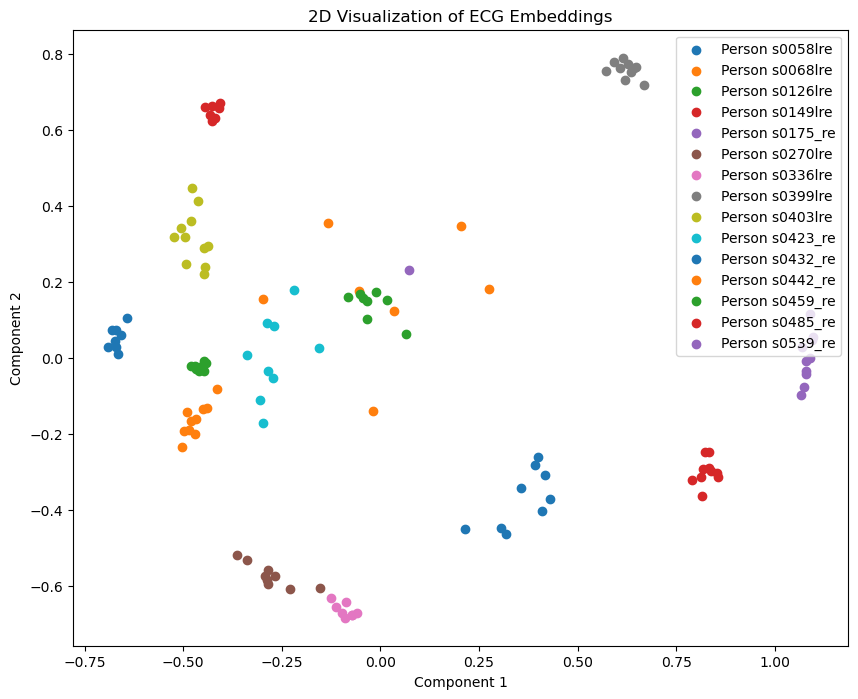

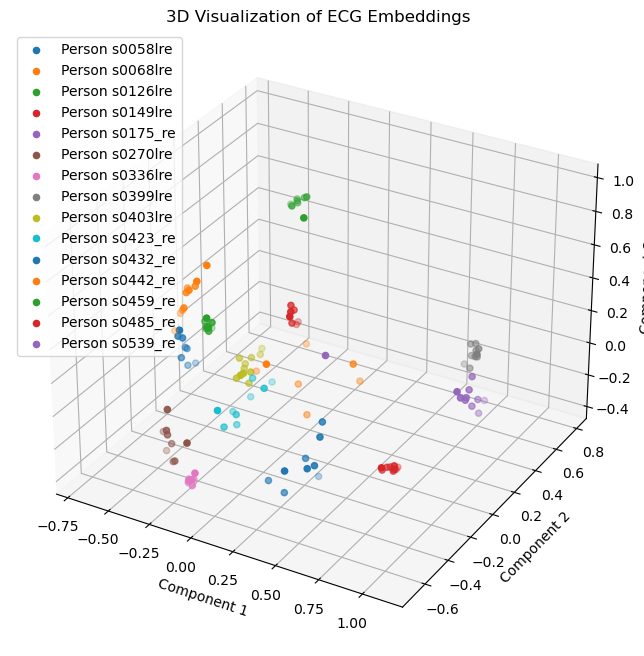

In [249]:
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score

# Assume `embeddings` is the output from your model and `labels` are the true labels
silhouette_avg = silhouette_score(embeddings_train, ptb_y_train)
print(f"Silhouette Score: {silhouette_avg}")

# Load the saved embedding model
# embedding_model = arcface_facenet_model
unique_classes = np.random.choice(np.unique(ptb_y_train), 15, replace=False)

# Create a mask to select only those embeddings and labels corresponding to the 5 unique classes
mask = np.isin(ptb_y_train, unique_classes)

# Filter the embeddings and labels
filtered_embeddings_train = embeddings_train[mask]
filtered_ptb_y_train = ptb_y_train[mask]
# Generate embeddings for the test set
X_test_embeddings = filtered_embeddings_train
y_test_embeddings=filtered_ptb_y_train
# Use PCA or t-SNE for dimensionality reduction
def reduce_dimensionality(embeddings, method='tsne', n_components=2):
    if method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=42)
        print(reducer)
    elif method == 'pca':
        reducer = PCA(n_components=n_components)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'")
    
    reduced_embeddings = reducer.fit_transform(embeddings)
    return reduced_embeddings

# Reduce embeddings to 2D for visualization
try:
    reduced_embeddings_2d = reduce_dimensionality(X_test_embeddings, method='pca', n_components=2)
except Exception as e:
    print(f"Error during dimensionality reduction: {e}")

# Ensure y_test is a numpy array and has the same length as reduced_embeddings_2d
# y_test = np.array(y_test[:60])

# Plot the 2D vector space
plt.figure(figsize=(10, 8))
try:
    for label in np.unique(y_test_embeddings):
        indices = np.where(y_test_embeddings == label)
        plt.scatter(reduced_embeddings_2d[indices, 0], reduced_embeddings_2d[indices, 1], label=f'Person {label}')
    plt.title('2D Visualization of ECG Embeddings')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Error during plotting: {e}")

# Reduce embeddings to 3D for visualization
try:
    reduced_embeddings_3d = reduce_dimensionality(X_test_embeddings, method='pca', n_components=3)
except Exception as e:
    print(f"Error during dimensionality reduction to 3D: {e}")

# Plot the 3D vector space
fig = plt.figure(figsize=(10, 8))
try:
    ax = fig.add_subplot(111, projection='3d')
    for label in np.unique(y_test_embeddings):
        indices = np.where(y_test_embeddings == label)
        ax.scatter(reduced_embeddings_3d[indices, 0], reduced_embeddings_3d[indices, 1], reduced_embeddings_3d[indices, 2], label=f'Person {label}')
    ax.set_title('3D Visualization of ECG Embeddings')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Error during 3D plotting: {e}")


### XGBoost  as Classifier

In [24]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, accuracy_score
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Load your CNN model
cnn_model = tf.keras.models.load_model('final_non_overlapping.h5', compile=False)

# Reshape the ECG data
ptbxl_X = X.reshape(-1, 3600, 1)
ptbxl_y = y

# Adjust the labels to start from 0
ptbxl_y = ptbxl_y - 1

ptb_X_train, ptb_X_test, ptb_y_train, ptb_y_test = train_test_split(ptbxl_X, ptbxl_y, test_size=0.2, random_state=42)

# Step 1: Generate embeddings for the test data
def generate_embeddings(model, X_):
    embeddings = model.predict(X_)
    return embeddings

# Generate embeddings for the train and test sets
embeddings_train = generate_embeddings(cnn_model, ptb_X_train)
embeddings_test = generate_embeddings(cnn_model, ptb_X_test)

# Step 2: Train an XGBoost classifier on the embeddings
xgb_model = XGBClassifier(objective='multi:softmax')
xgb_model.fit(embeddings_train, ptb_y_train)

# Step 3: Use the XGBoost model to predict the class of each test embedding
predicted_labels = xgb_model.predict(embeddings_test)

# Step 4: Calculate accuracy, precision, recall, and confusion matrix
accuracy = accuracy_score(ptb_y_test, predicted_labels)
precision = precision_score(ptb_y_test, predicted_labels, average='macro')
recall = recall_score(ptb_y_test, predicted_labels, average='macro')
f1_score_ = f1_score(ptb_y_test, predicted_labels, average='macro')
conf_matrix = confusion_matrix(ptb_y_test, predicted_labels)

# Print the evaluation metrics
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}".format(f1_score_))
print("Confusion Matrix:\n", conf_matrix)


36/36 [==============================] - 2s 64ms/step
Accuracy: 93.97%
Precision: 91.98%
Recall: 92.37%
F1 Score: 0.92
Confusion Matrix:
 [[5 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 6 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Neural Network As Classifier

In [34]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, accuracy_score
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np

# Load your CNN model
cnn_model = tf.keras.models.load_model('final_non_overlapping.h5', compile=False)

# Reshape the ECG data
ptbxl_X = X.reshape(-1, 3600, 1)
ptbxl_y = y

# Adjust the labels to start from 0
ptbxl_y = ptbxl_y - 1

ptb_X_train, ptb_X_test, ptb_y_train, ptb_y_test = train_test_split(ptbxl_X, ptbxl_y, test_size=0.2, random_state=42)

# Step 1: Generate embeddings for the test data
def generate_embeddings(model, X_):
    embeddings = model.predict(X_)
    return embeddings

# Generate embeddings for the train and test sets
embeddings_train = generate_embeddings(cnn_model, ptb_X_train)
embeddings_test = generate_embeddings(cnn_model, ptb_X_test)

# Step 2: Build a neural network classifier
def build_nn_classifier(input_shape, num_classes):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))  # Output layer for classification
    return model

# Get the number of classes from the unique labels
num_classes = len(np.unique(ptb_y_train))

# Build and compile the neural network classifier
nn_classifier = build_nn_classifier(input_shape=(embeddings_train.shape[1],), num_classes=num_classes)
nn_classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 3: Train the neural network classifier on the embeddings
nn_classifier.fit(embeddings_train, ptb_y_train, epochs=1000, batch_size=32, validation_split=0.1)

# Step 4: Use the neural network model to predict the class of each test embedding
predicted_labels = np.argmax(nn_classifier.predict(embeddings_test), axis=1)

# Step 5: Calculate accuracy, precision, recall, and confusion matrix
accuracy = accuracy_score(ptb_y_test, predicted_labels)
precision = precision_score(ptb_y_test, predicted_labels, average='macro')
recall = recall_score(ptb_y_test, predicted_labels, average='macro')
f1_score_ = f1_score(ptb_y_test, predicted_labels, average='macro')
conf_matrix = confusion_matrix(ptb_y_test, predicted_labels)

# Print the evaluation metrics
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}".format(f1_score_))
print("Confusion Matrix:\n", conf_matrix)


36/36 [==============================] - 2s 57ms/step
Epoch 1/1000
129/129 [==============================] - 1s 3ms/step - loss: 5.1767 - accuracy: 0.0599 - val_loss: 4.2471 - val_accuracy: 0.1507
Epoch 2/1000
129/129 [==============================] - 0s 2ms/step - loss: 3.7550 - accuracy: 0.1759 - val_loss: 2.8959 - val_accuracy: 0.3472
Epoch 3/1000
129/129 [==============================] - 0s 2ms/step - loss: 2.8979 - accuracy: 0.2788 - val_loss: 2.1175 - val_accuracy: 0.4760
Epoch 4/1000
129/129 [==============================] - 0s 2ms/step - loss: 2.4320 - accuracy: 0.3380 - val_loss: 1.7110 - val_accuracy: 0.5524
Epoch 5/1000
129/129 [==============================] - 0s 2ms/step - loss: 2.1512 - accuracy: 0.3967 - val_loss: 1.4359 - val_accuracy: 0.6026
Epoch 6/1000
129/129 [==============================] - 0s 2ms/step - loss: 1.9290 - accuracy: 0.4513 - val_loss: 1.2451 - val_accuracy: 0.6288
Epoch 7/1000
129/129 [==============================] - 0s 2ms/step - loss: 1.7961

Epoch 57/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.5127 - accuracy: 0.8250 - val_loss: 0.2297 - val_accuracy: 0.9389
Epoch 58/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.5057 - accuracy: 0.8263 - val_loss: 0.2114 - val_accuracy: 0.9498
Epoch 59/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.5188 - accuracy: 0.8231 - val_loss: 0.2097 - val_accuracy: 0.9541
Epoch 60/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.5014 - accuracy: 0.8289 - val_loss: 0.2170 - val_accuracy: 0.9410
Epoch 61/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.4951 - accuracy: 0.8328 - val_loss: 0.2230 - val_accuracy: 0.9432
Epoch 62/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.4897 - accuracy: 0.8350 - val_loss: 0.2063 - val_accuracy: 0.9498
Epoch 63/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.4918 - accuracy: 0.8352 - val_loss: 0.2052 - val_ac

129/129 [==============================] - 0s 2ms/step - loss: 0.3043 - accuracy: 0.8959 - val_loss: 0.1342 - val_accuracy: 0.9672
Epoch 170/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.2939 - accuracy: 0.8998 - val_loss: 0.1307 - val_accuracy: 0.9716
Epoch 171/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.2892 - accuracy: 0.9010 - val_loss: 0.1347 - val_accuracy: 0.9629
Epoch 172/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.2678 - accuracy: 0.9051 - val_loss: 0.1514 - val_accuracy: 0.9672
Epoch 173/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.2855 - accuracy: 0.9025 - val_loss: 0.1294 - val_accuracy: 0.9716
Epoch 174/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.2800 - accuracy: 0.8969 - val_loss: 0.1609 - val_accuracy: 0.9629
Epoch 175/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.2882 - accuracy: 0.8978 - val_loss: 0.1352 - val_accuracy: 

129/129 [==============================] - 0s 2ms/step - loss: 0.2107 - accuracy: 0.9236 - val_loss: 0.1124 - val_accuracy: 0.9738
Epoch 282/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.2172 - accuracy: 0.9257 - val_loss: 0.1154 - val_accuracy: 0.9738
Epoch 283/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.2084 - accuracy: 0.9265 - val_loss: 0.1244 - val_accuracy: 0.9738
Epoch 284/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.2094 - accuracy: 0.9250 - val_loss: 0.1174 - val_accuracy: 0.9716
Epoch 285/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.2204 - accuracy: 0.9185 - val_loss: 0.1291 - val_accuracy: 0.9694
Epoch 286/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.2315 - accuracy: 0.9199 - val_loss: 0.1187 - val_accuracy: 0.9694
Epoch 287/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.2366 - accuracy: 0.9202 - val_loss: 0.1275 - val_accuracy: 

129/129 [==============================] - 0s 2ms/step - loss: 0.1989 - accuracy: 0.9362 - val_loss: 0.1096 - val_accuracy: 0.9694
Epoch 394/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1870 - accuracy: 0.9401 - val_loss: 0.1214 - val_accuracy: 0.9694
Epoch 395/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1926 - accuracy: 0.9352 - val_loss: 0.1099 - val_accuracy: 0.9716
Epoch 396/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1695 - accuracy: 0.9403 - val_loss: 0.0982 - val_accuracy: 0.9803
Epoch 397/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1815 - accuracy: 0.9357 - val_loss: 0.1023 - val_accuracy: 0.9782
Epoch 398/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1905 - accuracy: 0.9350 - val_loss: 0.1067 - val_accuracy: 0.9760
Epoch 399/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1806 - accuracy: 0.9391 - val_loss: 0.1156 - val_accuracy: 

129/129 [==============================] - 0s 2ms/step - loss: 0.1810 - accuracy: 0.9401 - val_loss: 0.1281 - val_accuracy: 0.9716
Epoch 506/1000
129/129 [==============================] - 0s 3ms/step - loss: 0.1547 - accuracy: 0.9464 - val_loss: 0.1207 - val_accuracy: 0.9738
Epoch 507/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1636 - accuracy: 0.9452 - val_loss: 0.1158 - val_accuracy: 0.9760
Epoch 508/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1543 - accuracy: 0.9442 - val_loss: 0.1088 - val_accuracy: 0.9694
Epoch 509/1000
129/129 [==============================] - 0s 3ms/step - loss: 0.1589 - accuracy: 0.9461 - val_loss: 0.1181 - val_accuracy: 0.9672
Epoch 510/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1486 - accuracy: 0.9483 - val_loss: 0.1071 - val_accuracy: 0.9716
Epoch 511/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1750 - accuracy: 0.9439 - val_loss: 0.1130 - val_accuracy: 

129/129 [==============================] - 0s 2ms/step - loss: 0.1513 - accuracy: 0.9503 - val_loss: 0.1405 - val_accuracy: 0.9760
Epoch 618/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1596 - accuracy: 0.9452 - val_loss: 0.1243 - val_accuracy: 0.9716
Epoch 619/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1269 - accuracy: 0.9556 - val_loss: 0.1126 - val_accuracy: 0.9716
Epoch 620/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1495 - accuracy: 0.9512 - val_loss: 0.1399 - val_accuracy: 0.9672
Epoch 621/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1430 - accuracy: 0.9503 - val_loss: 0.1209 - val_accuracy: 0.9760
Epoch 622/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1527 - accuracy: 0.9471 - val_loss: 0.1044 - val_accuracy: 0.9760
Epoch 623/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1522 - accuracy: 0.9449 - val_loss: 0.1233 - val_accuracy: 

129/129 [==============================] - 0s 2ms/step - loss: 0.1502 - accuracy: 0.9503 - val_loss: 0.1258 - val_accuracy: 0.9716
Epoch 730/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1384 - accuracy: 0.9558 - val_loss: 0.1267 - val_accuracy: 0.9651
Epoch 731/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1486 - accuracy: 0.9495 - val_loss: 0.1370 - val_accuracy: 0.9694
Epoch 732/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1550 - accuracy: 0.9473 - val_loss: 0.1242 - val_accuracy: 0.9760
Epoch 733/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1399 - accuracy: 0.9524 - val_loss: 0.1485 - val_accuracy: 0.9738
Epoch 734/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1489 - accuracy: 0.9512 - val_loss: 0.1261 - val_accuracy: 0.9716
Epoch 735/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1333 - accuracy: 0.9524 - val_loss: 0.1278 - val_accuracy: 

129/129 [==============================] - 0s 2ms/step - loss: 0.1218 - accuracy: 0.9546 - val_loss: 0.1173 - val_accuracy: 0.9760
Epoch 842/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1331 - accuracy: 0.9592 - val_loss: 0.1140 - val_accuracy: 0.9738
Epoch 843/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1279 - accuracy: 0.9573 - val_loss: 0.1178 - val_accuracy: 0.9782
Epoch 844/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1260 - accuracy: 0.9554 - val_loss: 0.1427 - val_accuracy: 0.9782
Epoch 845/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1435 - accuracy: 0.9580 - val_loss: 0.1192 - val_accuracy: 0.9803
Epoch 846/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1254 - accuracy: 0.9551 - val_loss: 0.1381 - val_accuracy: 0.9716
Epoch 847/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1225 - accuracy: 0.9575 - val_loss: 0.1313 - val_accuracy: 

129/129 [==============================] - 0s 3ms/step - loss: 0.1184 - accuracy: 0.9575 - val_loss: 0.1256 - val_accuracy: 0.9803
Epoch 954/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1215 - accuracy: 0.9585 - val_loss: 0.1175 - val_accuracy: 0.9803
Epoch 955/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1186 - accuracy: 0.9604 - val_loss: 0.1291 - val_accuracy: 0.9782
Epoch 956/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1252 - accuracy: 0.9619 - val_loss: 0.1170 - val_accuracy: 0.9760
Epoch 957/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1310 - accuracy: 0.9537 - val_loss: 0.1204 - val_accuracy: 0.9738
Epoch 958/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1389 - accuracy: 0.9522 - val_loss: 0.1130 - val_accuracy: 0.9782
Epoch 959/1000
129/129 [==============================] - 0s 2ms/step - loss: 0.1343 - accuracy: 0.9566 - val_loss: 0.1391 - val_accuracy: 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
# Calculate precision, recall, and confusion matrix
precision = precision_score(ptb_y_test, predictions, average='macro')
recall = recall_score(ptb_y_test, predictions, average='macro')
conf_matrix = confusion_matrix(ptb_y_test, predictions)
accuracy = accuracy_score(ptb_y_test, predictions)

# print("Precision: {:.2f}%".format(precision * 100))
# print("Recall: {:.2f}%".format(recall * 100))
f1_score_=f1_score(ptb_y_test, predictions, average='macro')
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score:" + str(f1_score_ ))
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 93.97%
Precision: 91.98%
Recall: 92.37%
F1 Score:0.9156474388172815
Confusion Matrix:
 [[5 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 6 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
unique_labels = np.unique(ptb_y_test)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix,  fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

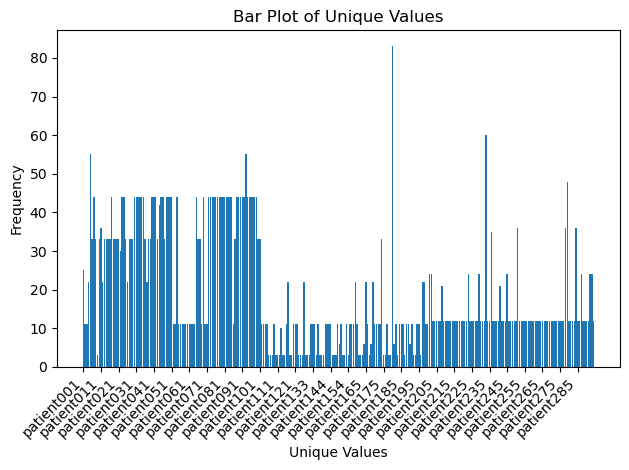

19.73793103448276


In [335]:
unique, frequency = np.unique(y,
                              return_counts = True) 
# print(unique)

plt.bar(unique, frequency)
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.title('Bar Plot of Unique Values')
# plt.show()
n = 10
plt.xticks(ticks=unique[::n], labels=unique[::n], rotation=45, ha='right')
# Add padding to avoid label cutoff
plt.tight_layout()

plt.show()
print(sum(frequency)/len(frequency))

In [329]:
print("no of unique persons",len(np.unique(ptb_y_train)))

no of unique persons 290


In [191]:
print("no of training samples for KNN ",ptb_y_train.shape)

no of training samples for KNN  (4579,)


In [192]:
ptb_y_train

array(['s0082lre', 's0466_re', 's0247lre', ..., 's0499_re', 's0527_re',
       's0093lre'], dtype='<U8')